# miniVLA: VLA Model from scratch for understanding VLA

Reference: https://medium.com/@mrshahzebkhoso/i-built-and-tested-visual-language-action-from-scratch-a-beginner-friendly-guide-48c04e7c6c2a

$$a @ \pi(I_e, T_e) = p(a| [I_e, T_e])$$

I_e: Image Encoder output and T_e: Text encoder output

In [1]:
import gymnasium as gym
import numpy as np
from PIL import Image, ImageDraw

class MiniCartPoleVisionEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.action_space = gym.spaces.Discrete(2)
        self.observation_space = gym.spaces.Box(
            0, 255, shape=(64, 64, 3), dtype=np.uint8
        )
        self.x = 0.0
        self.theta = 0.0

    def reset(self, seed=None, options=None):
        self.x = 0.0
        self.theta = 0.1
        return self.render(), {}

    def step(self, action):
        self.x += (0.05 if action == 1 else -0.05)
        self.theta += np.random.randn() * 0.02

        reward = -abs(self.theta)
        terminated = abs(self.theta) > 0.5
        truncated = False

        return self.render(), reward, terminated, truncated, {}

    def render(self):
        img = Image.new("RGB", (64, 64), "white")
        d = ImageDraw.Draw(img)

        cx = int(32 + self.x * 300)
        d.rectangle([cx-8, 40, cx+8, 50], fill="black")

        px = cx + int(20 * np.sin(self.theta))
        py = 20
        d.line((cx, 40, px, py), fill="red", width=3)

        return np.array(img)

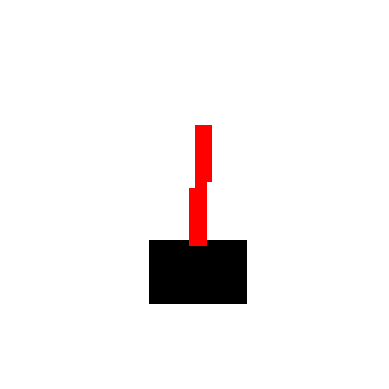

In [2]:
import matplotlib.pyplot as plt

env = MiniCartPoleVisionEnv()
obs, _ = env.reset()

plt.imshow(obs)
plt.axis('off')
plt.show()


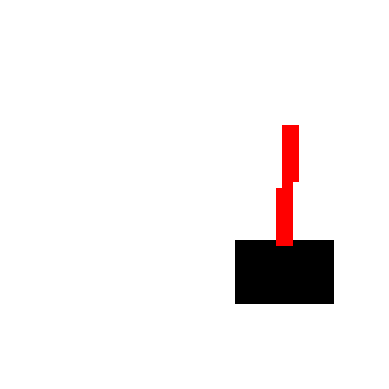

In [3]:
action = 1 # 1: Move to Right, 0: Move to Left
obs, reward, terminated, truncated, _ = env.step(action)

plt.imshow(obs)
plt.axis('off')
plt.pause(0.1)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MiniVLA(nn.Module):
    def __init__(self, num_actions=2, vocab_size=1000, embed_dim=32):
        super().__init__()

        # Simple vision encoder (ConvNet)
        self.vision = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Vision embedding dimension after flatten
        self.vision_out = 32 * 16 * 16

        # Language encoder (bag-of-words -> embedding)
        self.text_embed = nn.Linear(vocab_size, embed_dim)

        # Fusion + Action head
        self.policy = nn.Sequential(
            nn.Linear(self.vision_out + embed_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_actions)
        )

    def forward(self, image, bow_text):
        v = image / 255.0
        v = v.permute(0, 3, 1, 2)  # NHWC -> NCHW
        v = self.vision(v)

        t = self.text_embed(bow_text)

        fused = torch.cat([v, t], dim=-1)
        logits = self.policy(fused)
        action_prob = torch.softmax(logits, dim=-1)
        return action_prob

In [5]:
def make_bow_instruction(text, vocab_size=1000):
    bow = torch.zeros(vocab_size)
    for w in text.lower().split():
        idx = abs(hash(w)) % vocab_size
        bow[idx] += 1
    return bow

In [6]:
# Create environment
env = MiniCartPoleVisionEnv()
obs, _ = env.reset()

# Create VLA
model = MiniVLA()
model.eval()

instruction = "keep the pole upright"
bow = make_bow_instruction(instruction).unsqueeze(0)

for step in range(5):
    img = torch.tensor(obs).float().unsqueeze(0)

    with torch.no_grad():
        action_prob = model(img, bow)
        action = torch.argmax(action_prob, dim=-1).item()

    obs, reward, done, truncated, info = env.step(action)
    print(f"step={step}, action={action}, reward={reward:.3f}")

    if done:
        print("Episode ended.")
        break
     


step=0, action=0, reward=-0.089
step=1, action=1, reward=-0.097
step=2, action=0, reward=-0.091
step=3, action=1, reward=-0.093
step=4, action=0, reward=-0.125


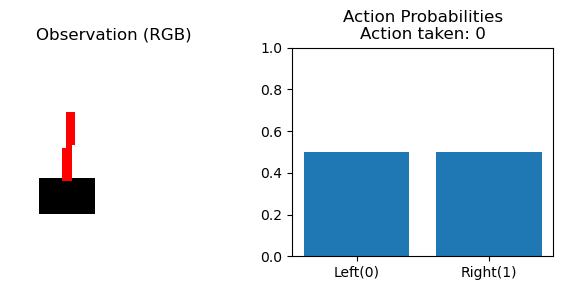

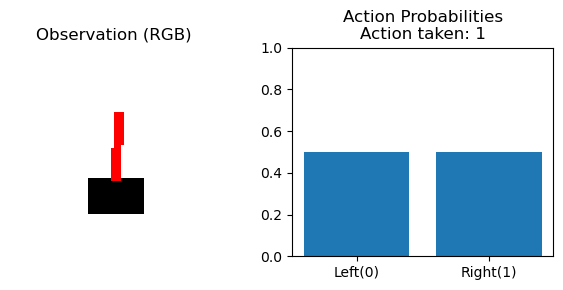

In [7]:
import matplotlib.pyplot as plt
import torch

obs, _ = env.reset()
instruction = "keep the pole upright"
bow = make_bow_instruction(instruction).unsqueeze(0)
for step in range(2):

    # convert observation (image) to tensor
    img_t = torch.tensor(obs).float().unsqueeze(0)   # (1, H, W, 3)

    # model already returns probabilities!
    with torch.no_grad():
        probs = model(img_t, bow).squeeze().numpy()  # shape: (2,)
        action = int(probs.argmax())

    # environment step
    obs, reward, done, _, _ = env.step(action)

    # visualization
    plt.figure(figsize=(6, 3))

    # --- IMAGE DISPLAY ---
    plt.subplot(1, 2, 1)
    plt.imshow(obs)       # obs must be a uint8 RGB image
    plt.axis("off")
    plt.title("Observation (RGB)")

    # --- PROBABILITIES DISPLAY ---
    plt.subplot(1, 2, 2)
    plt.bar(["Left(0)", "Right(1)"], probs)
    plt.ylim(0, 1)
    plt.title(f"Action Probabilities\nAction taken: {action}")

    plt.tight_layout()
    display(plt.gcf())
    plt.close()

    if done:
        print("Episode finished.")
        break